This file will plot the SADs for the adults and juveniles combined dataset by land use.

In [8]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sad_mrdi as sm
%matplotlib inline

In [9]:
# Import data
df = pd.read_csv('./RawData/Azores_Combined.csv',header=[0,1])

In [10]:
# Some more preamble and calculating some state variables

# Verify we have the correct number of sites per land use
print("Native forest: {} sites".format(len(df['Native forest'].columns)))
print("Exotic forest: {} sites".format(len(df['Exotic forest'].columns)))
print("Semi-natural pasture: {} sites".format(len(df['Semi-natural pasture'].columns)))
print("Intensive pasture: {} sites".format(len(df['Intensive pasture'].columns)))
print()
# Get total s0
s0 = len(df)
print('Number of species: {}'.format(s0)) # Or ad['Data','MF'].nunique()
# Practice some fancy indexing (more here https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)
# Get land use types
lu = list(df.columns.levels[0])
lu.remove('Data')
# Reorder to disturbance gradient
lu = [lu[2],lu[0],lu[3],lu[1]]
# Get length to use to loop over etc.
lutypes = len(lu)
# Get total n0
n0 = df[lu].sum().sum()
print('Number of individuals: {}'.format(n0))

Native forest: 44 sites
Exotic forest: 12 sites
Semi-natural pasture: 16 sites
Intensive pasture: 24 sites

Number of species: 271
Number of individuals: 46250


# Abundances

In [11]:
# Get s0 and n0 for each different environment

# Make arrays
# For s,n,beta
sn_lu = pd.DataFrame(index=lu,columns = {'s0','n0','beta'})
# For abundances
abd_lu = pd.DataFrame(columns=lu)
for l in lu:
    abd_lu[l] = df[l].sum(axis=1)
    # Get n0 and s0
    stemp = np.count_nonzero(abd_lu[l])
    ntemp = abd_lu[l].sum()
    # Get beta
    btemp = sm.get_beta(stemp,ntemp)
    # Add to dataframe
    sn_lu.loc[l] = {'n0': ntemp, 's0': stemp, 'beta': btemp}

# Rename indexes for abundaces to species code
abd_lu.rename(index=df['Data','MF'],inplace=True)
abd_lu.index.name = 'MF'

# Fix datatype for sn_lu
sn_lu = sn_lu.astype({'s0': 'int64','n0':'int64','beta':'float64'})

sn_lu

,beta,n0,s0
Native forest,0.002377,10291,148
Exotic forest,0.004800,3385,87
Semi-natural pasture,0.001750,11421,127
Intensive pasture,0.000919,21153,136


# Goodness of fit

### Mean least squares

In [12]:
# Get least squares for each site
# Create new array for empirical log likelihood
mlsq = pd.Series(index=lu,dtype='float64')

for l in lu:
    ranks = np.arange(sn_lu['s0'][l])+1
    theory = sm.sad_rank(ranks,sn_lu['s0'][l],sn_lu['beta'][l])
    abd = abd_lu[l]
    emp = np.sort(abd[abd!=0])[::-1]
    # Calculate least squares of log
    if sn_lu['s0'][l] == len(emp):
        if sn_lu['n0'][l] == sum(emp):
            mlsq[l] = np.sum((np.log(theory)-np.log(emp))**2)/len(emp)
        else:
            print("Ruh ro! 1")
    else:
        print("Ruh ro! 2")
print('Mean least squares')
display(mlsq)
sn_lu['mlsq'] = mlsq

Mean least squares


Native forest           0.491278
Exotic forest           0.689149
Semi-natural pasture    1.257251
Intensive pasture       0.331208
dtype: float64

# Plots

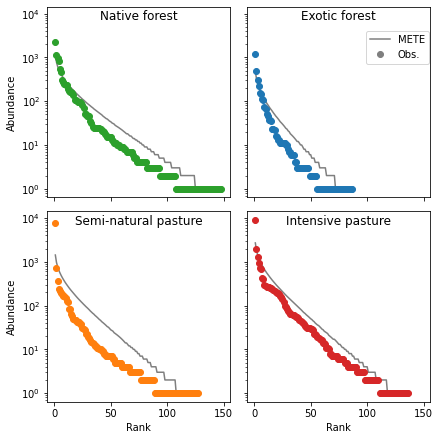

In [13]:
clist = {lu[0]:'tab:green',lu[1]:'tab:blue',lu[2]:'tab:orange',lu[3]:'tab:red'}
fig,axs = plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True,constrained_layout=True)
for l, ax in zip(lu,fig.axes):
    # Set title to index
    ax.set_title(l,y=0.9)
    # Plot theoretical SAD
    ranks = np.arange(sn_lu['s0'][l])+1
    ax.semilogy(ranks,sm.sad_rank(ranks,sn_lu['s0'][l],sn_lu['beta'][l]),c='tab:gray',label='METE')
    # Plot empirical SAD
    abd = np.sort(abd_lu[l].values)[::-1]
    ax.semilogy(ranks,abd[abd != 0],'o',c=clist[l],label='Obs.')

mete, = axs[0,1].semilogy([],[],c='tab:gray',label='METE')
obs, = axs[0,1].semilogy([],[],'o',c='tab:gray',label='Obs.')

axs[0,1].legend(handles=[mete,obs],loc=(0.65,0.7))#'center right')

axs[0,0].set_ylabel('Abundance')
axs[1,0].set_ylabel('Abundance')
axs[1,0].set_xlabel('Rank')
axs[1,1].set_xlabel('Rank')

fig.savefig('Figures/SI/SAD_LandUse.pdf')

In [14]:
sn_lu.to_csv('ProcessedData/sad_combined_data.csv')